In [1]:
!pip install -q torch torchvision tqdm einops torch_ema
import numpy as np
import math, os, random, time, csv, pickle
from pathlib import Path
from tqdm import tqdm

import torch
import time
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torchvision import transforms, datasets

from einops import rearrange
from copy import deepcopy

In [2]:
device = torch.device("mps" if torch.backends.mps.is_available()
                      else "cuda" if torch.cuda.is_available()
                      else "cpu")
print("device:", device)

cfg = {
    "image_size": 32,
    "patch_size": 4,          # not directly used now, but kept for reference
    "in_channels": 3,
    "num_classes": 100,

    # ViT size – scratch-friendly
    "emb_dim": 192,
    "num_heads": 6,
    "depth": 6,
    "mlp_ratio": 4.0,

    # regularization 
    "drop": 0.0,          # dropout OFF, rely on drop_path
    "drop_path": 0.05,    # mild stochastic depth

    "batch_size": 128,
    "epochs": 200,
    "lr": 4e-4,
    "weight_decay": 0.05,
    "warmup_epochs": 5,
    "label_smoothing": 0.03,
    "ema_decay": 0.9999,
    "seed": 42,

    # CTD config
    "use_token_drop": True,
    "ctd_initial_drop": 0.0,   # drop 0% at start of CTD
    "ctd_final_drop": 0.35,    # drop up to 35% of tokens
    "ctd_start_epoch": 40,     # curriculum from epoch 40
    "ctd_end_epoch": 140,      # ... to epoch 140
    "ctd_gamma": 2.0,          # slower at start, stronger later
    "ctd_block_idx": 0,        # which block to apply CTD in

    "mixup_alpha": 0.8,
    "cutmix_alpha": 1.0,
    "cutmix_prob": 0.5,
}

# reproducibility
torch.manual_seed(cfg["seed"])
random.seed(cfg["seed"])


device: mps


In [3]:
mean = (0.5071, 0.4867, 0.4408)
std  = (0.2675, 0.2565, 0.2761)

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.RandAugment(num_ops=2, magnitude=7),   # softer than 10
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.1, value='random'),  # softer than 0.25
    transforms.Normalize(mean, std),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_ds = datasets.CIFAR100(root="data", train=True, download=True, transform=train_transform)
test_ds  = datasets.CIFAR100(root="data", train=False, download=True, transform=test_transform)

pin = (device.type == "cuda")

train_loader = DataLoader(
    train_ds,
    batch_size=cfg["batch_size"],
    shuffle=True,
    num_workers=2,
    pin_memory=pin,
)

test_loader  = DataLoader(
    test_ds,
    batch_size=256,
    shuffle=False,
    num_workers=2,
    pin_memory=pin,
)


In [4]:
class ConvPatchEmbed(nn.Module):
    def __init__(self, in_chans=3, embed_dim=192, img_size=32):
        super().__init__()
        self.img_size = img_size
        # 32x32 -> 32x32 -> 16x16 -> 16x16  (256 tokens)
        self.conv = nn.Sequential(
            nn.Conv2d(in_chans, 64, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),  # 32 -> 16
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),

            nn.Conv2d(128, embed_dim, kernel_size=3, stride=1, padding=1, bias=False),  # stay 16x16
            nn.BatchNorm2d(embed_dim),
            nn.ReLU(inplace=True),
        )
        grid = img_size // 2        # 32 / 2 = 16
        self.n_patches = grid * grid   # 16x16 = 256

    def forward(self, x):
        x = self.conv(x)          # (B, E, 16, 16)
        x = x.flatten(2)          # (B, E, N)
        x = x.transpose(1, 2)     # (B, N, E)
        return x


class MLP(nn.Module):
    def __init__(self, in_features, hidden_features=None, drop=0.):
        super().__init__()
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.GELU()
        self.fc2 = nn.Linear(hidden_features, in_features)
        self.drop = nn.Dropout(drop)
    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim*3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x, return_attn=False):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads)\
                         .permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]   # (B, heads, N, head_dim)
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)        # (B, heads, N, N)
        attn_dropped = self.attn_drop(attn)
        x = (attn_dropped @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        if return_attn:
            return x, attn
        return x


class _StochasticDepth(nn.Module):
    def __init__(self, p):
        super().__init__()
        self.p = p
    def forward(self, x):
        if not self.training or self.p == 0.:
            return x
        keep = torch.rand(x.shape[0], 1, 1, device=x.device) >= self.p
        return x * keep / (1 - self.p)


class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., drop=0., attn_drop=0., drop_path=0.):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = Attention(dim, num_heads=num_heads,
                              attn_drop=attn_drop, proj_drop=drop)
        self.drop_path = nn.Identity() if drop_path == 0. else _StochasticDepth(drop_path)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = MLP(dim, int(dim*mlp_ratio), drop=drop)

    def _get_drop_ratio(self, epoch: int):
        # CTD schedule from cfg
        start = cfg.get("ctd_start_epoch", 0)
        end   = cfg.get("ctd_end_epoch", cfg["epochs"])
        init  = cfg.get("ctd_initial_drop", 0.0)
        final = cfg.get("ctd_final_drop", 0.3)
        gamma = cfg.get("ctd_gamma", 1.0)

        if epoch is None:
            return 0.0
        if epoch < start:
            return init
        if epoch >= end:
            return final

        p = (epoch - start) / max(1, end - start)
        p = p ** gamma
        return init + p * (final - init)

    def forward(self, x, epoch=None):
        # We only enable CTD when epoch is not None AND the flag is set
        use_ctd = self.training and (epoch is not None) and cfg.get("use_token_drop", False)

        if not use_ctd:
            # standard transformer block
            x = x + self.drop_path(self.attn(self.norm1(x)))
            x = x + self.drop_path(self.mlp(self.norm2(x)))
            return x

        # ===== Curriculum Token Drop path (applied only in one chosen block) =====
        drop_ratio = self._get_drop_ratio(epoch)
        if drop_ratio <= 1e-6:
            # effectively no drop
            x = x + self.drop_path(self.attn(self.norm1(x)))
            x = x + self.drop_path(self.mlp(self.norm2(x)))
            return x

        B, N_plus_1, C = x.shape
        if N_plus_1 <= 1:
            # no patches, nothing to drop
            x = x + self.drop_path(self.attn(self.norm1(x)))
            x = x + self.drop_path(self.mlp(self.norm2(x)))
            return x

        # norm and attention
        normed = self.norm1(x)
        attn_out, attn_weights = self.attn(normed, return_attn=True)  # attn_weights: (B, heads, N, N)

        # CLS -> patch saliency: mean over heads, then take CLS row, skip CLS column
        saliency = attn_weights.mean(dim=1)[:, 0, 1:]   # (B, N_patches)
        N_patches = saliency.shape[1]

        keep = max(1, int(N_patches * (1.0 - drop_ratio)))
        if keep >= N_patches:
            # nothing to drop
            x = x + self.drop_path(attn_out)
            x = x + self.drop_path(self.mlp(self.norm2(x)))
            return x

        # pick top-k salient tokens
        _, idx = torch.topk(saliency, k=keep, dim=1, largest=True, sorted=False)  # (B, keep)

        # separate cls and patch tokens
        cls_x = x[:, :1, :]             # (B, 1, C)
        tokens_x = x[:, 1:, :]          # (B, N_patches, C)

        cls_attn = attn_out[:, :1, :]   # (B, 1, C)
        tokens_attn = attn_out[:, 1:, :]# (B, N_patches, C)

        # gather along tokens dimension using idx
        idx_expanded = idx.unsqueeze(-1).expand(-1, -1, C)  # (B, keep, C)

        kept_x = torch.gather(tokens_x, 1, idx_expanded)       # (B, keep, C)
        kept_attn = torch.gather(tokens_attn, 1, idx_expanded) # (B, keep, C)

        x_new = torch.cat([cls_x, kept_x], dim=1)              # (B, 1+keep, C)
        attn_new = torch.cat([cls_attn, kept_attn], dim=1)     # (B, 1+keep, C)

        # residual + MLP
        x_new = x_new + self.drop_path(attn_new)
        x_new = x_new + self.drop_path(self.mlp(self.norm2(x_new)))
        return x_new


class ViT(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.cfg = cfg
        self.patch_embed = ConvPatchEmbed(cfg["in_channels"], cfg["emb_dim"],
                                          img_size=cfg.get("image_size", 32))
        n_patches = self.patch_embed.n_patches   # 256

        self.cls_token = nn.Parameter(torch.zeros(1, 1, cfg["emb_dim"]))
        self.pos_embed = nn.Parameter(torch.zeros(1, 1 + n_patches, cfg["emb_dim"]))
        self.pos_drop = nn.Dropout(p=cfg["drop"])

        dpr = [x.item() for x in torch.linspace(0, cfg.get("drop_path", 0.2), cfg["depth"])]
        self.blocks = nn.ModuleList([
            Block(cfg["emb_dim"], num_heads=cfg["num_heads"],
                  mlp_ratio=cfg["mlp_ratio"], drop=cfg["drop"], drop_path=dpr[i])
            for i in range(cfg["depth"])
        ])
        self.norm = nn.LayerNorm(cfg["emb_dim"])
        self.head = nn.Linear(cfg["emb_dim"], cfg["num_classes"])

        # choose which block to apply CTD in
        self.ctd_block_idx = cfg.get("ctd_block_idx", 0)  # default: first block

        nn.init.trunc_normal_(self.pos_embed, std=.02)
        nn.init.trunc_normal_(self.cls_token, std=.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.LayerNorm):
            nn.init.zeros_(m.bias)
            nn.init.ones_(m.weight)
        elif isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            if getattr(m, "bias", None) is not None:
                nn.init.zeros_(m.bias)

    def forward(self, x, epoch=None):
        B = x.shape[0]
        x = self.patch_embed(x)             # (B, N, E)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)   # (B, 1+N, E)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        for i, blk in enumerate(self.blocks):
            if self.training and (epoch is not None) and cfg.get("use_token_drop", False) and (i == self.ctd_block_idx):
                x = blk(x, epoch=epoch)       # CTD active here
            else:
                x = blk(x, epoch=None)        # CTD off for this block

        x = self.norm(x)
        cls = x[:, 0]
        out = self.head(cls)
        return out


In [5]:
model = ViT(cfg).to(device)

try:
    from torch_ema import ExponentialMovingAverage
    ema = ExponentialMovingAverage(model.parameters(), decay=cfg["ema_decay"])
    use_ema = True
    print("Using EMA")
except ImportError:
    ema = None
    use_ema = False
    print("torch_ema not found, skipping EMA")

optimizer = AdamW(model.parameters(), lr=cfg["lr"], weight_decay=cfg["weight_decay"])

def lr_lambda(epoch):
    # epoch-based warmup + cosine
    warmup_epochs = cfg["warmup_epochs"]
    total_epochs = cfg["epochs"]

    if epoch < warmup_epochs:
        return float(epoch + 1) / float(max(1, warmup_epochs))
    progress = float(epoch + 1 - warmup_epochs) / float(max(1, total_epochs - warmup_epochs))
    return 0.5 * (1.0 + math.cos(math.pi * progress))

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

criterion = nn.CrossEntropyLoss(label_smoothing=cfg["label_smoothing"])

Using EMA


In [7]:
# Mixup / CutMix function
def mixup_cutmix(images, targets, mixup_alpha, cutmix_alpha, cutmix_prob):
    B, C, H, W = images.size()

    mix = np.random.rand()
    if mix < cutmix_prob:   # CutMix
        lam = np.random.beta(cutmix_alpha, cutmix_alpha)
        rx = np.random.randint(W)
        ry = np.random.randint(H)
        rw = int(W * np.sqrt(1 - lam))
        rh = int(H * np.sqrt(1 - lam))
        x1 = np.clip(rx - rw // 2, 0, W)
        y1 = np.clip(ry - rh // 2, 0, H)
        x2 = np.clip(rx + rw // 2, 0, W)
        y2 = np.clip(ry + rh // 2, 0, H)

        indices = torch.randperm(B).to(images.device)
        images[:, :, y1:y2, x1:x2] = images[indices, :, y1:y2, x1:x2]
        lam = 1 - ((x2 - x1) * (y2 - y1) / (W * H))
        y1, y2 = targets, targets[indices]

    else:                   # Mixup
        lam = np.random.beta(mixup_alpha, mixup_alpha)
        indices = torch.randperm(B).to(images.device)
        images = lam * images + (1 - lam) * images[indices]
        y1, y2 = targets, targets[indices]

    return images, (y1, y2, lam)


In [8]:
def train_one_epoch(model, loader, optimizer, epoch):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0

    pbar = tqdm(loader, desc=f"Train Epoch {epoch}")

    for images, targets in pbar:
        images, targets = images.to(device), targets.to(device)

        # Mixup / Cutmix (training only)
        if cfg["mixup_alpha"] > 0 or cfg["cutmix_alpha"] > 0:
            images, y_tuple = mixup_cutmix(
                images, targets,
                cfg["mixup_alpha"],
                cfg["cutmix_alpha"],
                cfg["cutmix_prob"],
            )
            y1, y2, lam = y_tuple
        else:
            y1, y2, lam = targets, targets, 1.0

        # Forward
        outputs = model(images)

        # Loss (mixup/cutmix aware)
        loss = lam * criterion(outputs, y1) + (1 - lam) * criterion(outputs, y2)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step(set_to_none=True)

        running_loss += loss.item() * images.size(0)

        # Accuracy (convert mixup/cutmix prediction to normal accuracy)
        _, preds = outputs.max(1)
        total += targets.size(0)
        correct += preds.eq(targets).sum().item()

        pbar.set_postfix(acc=100*correct/total, loss=running_loss/total)

    return running_loss / total, 100 * correct / total

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    total, correct = 0, 0
    losses = 0.0

    for images, targets in loader:
        images, targets = images.to(device), targets.to(device)
        outputs = model(images)
        loss = criterion(outputs, targets)
        losses += loss.item() * images.size(0)

        _, preds = outputs.max(1)
        total += targets.size(0)
        correct += preds.eq(targets).sum().item()

    return losses / total, 100 * correct / total


In [9]:
history = []
csv_file = "New_CTD_ViT_metrics.csv"
with open(csv_file, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow([
        "epoch",
        "train_loss",
        "train_acc_clean",
        "val_loss_raw",
        "val_acc_raw",
        "val_loss_ema",
        "val_acc_ema",
        "lr",
        "epoch_time_sec"
    ])

best_acc = 0
total_epochs = cfg["epochs"]

for epoch in range(total_epochs):
    start_time = time.time()

    model.train()
    running_loss = 0.0
    total = 0
    correct_clean = 0  # <-- clean accuracy on original GT

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}")

    for images, targets in pbar:
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()

        # Mixup/CutMix
        images, (y1, y2, lam) = mixup_cutmix(
            images, targets,
            cfg["mixup_alpha"], cfg["cutmix_alpha"], cfg["cutmix_prob"]
        )

        outputs = model(images, epoch=epoch)
        loss = lam * criterion(outputs, y1) + (1 - lam) * criterion(outputs, y2)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        if ema is not None:
            ema.update()

        running_loss += loss.item() * images.size(0)
        total += targets.size(0)

        # clean classification accuracy (compare with GT)
        _, preds = outputs.max(1)
        correct_clean += preds.eq(targets).sum().item()

        pbar.set_postfix(loss=running_loss/total, clean_acc=100.*correct_clean/total)

    train_loss = running_loss / total
    train_acc_clean = 100. * correct_clean / total

    # Validation (raw)
    val_loss_raw, val_acc_raw = evaluate(model, test_loader)

    # Validation (EMA)
    if ema is not None:
        backup = deepcopy(model.state_dict())
        ema.copy_to(model.parameters())
        val_loss_ema, val_acc_ema = evaluate(model, test_loader)
        model.load_state_dict(backup)
    else:
        val_loss_ema, val_acc_ema = val_loss_raw, val_acc_raw

    scheduler.step()
    lr_now = optimizer.param_groups[0]["lr"]
    epoch_time = time.time() - start_time

    print(
        f">>> Epoch {epoch:03d} | "
        f"train_clean: {train_acc_clean:.2f}% | "
        f"val_raw: {val_acc_raw:.2f}% | "
        f"val_EMA: {val_acc_ema:.2f}% | "
        f"time: {epoch_time:.1f}s"
    )

    # save best based on EMA accuracy
    if val_acc_ema > best_acc:
        best_acc = val_acc_ema
        torch.save({
            "epoch": epoch,
            "model_state": model.state_dict(),
            "optimizer": optimizer.state_dict(),
            "best_acc": best_acc
        }, "best_CTD_Mixup_EMA_checkpoint.pth")
        print(f"New Best EMA Model Saved: {best_acc:.2f}%")

    # write to CSV
    with open(csv_file, "a", newline="") as f:
        writer = csv.writer(f)
        writer.writerow([
            epoch,
            train_loss,
            train_acc_clean,
            val_loss_raw,
            val_acc_raw,
            val_loss_ema,
            val_acc_ema,
            lr_now,
            epoch_time
        ])

print("\nTraining Finished!")
print(f"Best EMA Validation Accuracy: {best_acc:.2f}%")

torch.save(model.state_dict(), "final_raw_model.pth")
if ema is not None:
    ema.copy_to(model.parameters())
    torch.save(model.state_dict(), "final_EMA_model.pth")
    print("Saved both raw & EMA final models")


Epoch 0: 100%|█████| 391/391 [03:44<00:00,  1.74it/s, clean_acc=4.72, loss=4.38]


>>> Epoch 000 | train_clean: 4.72% | val_raw: 12.67% | val_EMA: 12.60% | time: 276.1s
New Best EMA Model Saved: 12.60%


Epoch 1: 100%|█████| 391/391 [03:43<00:00,  1.75it/s, clean_acc=7.37, loss=4.15]


>>> Epoch 001 | train_clean: 7.37% | val_raw: 18.01% | val_EMA: 18.01% | time: 279.2s
New Best EMA Model Saved: 18.01%


Epoch 2: 100%|█████| 391/391 [03:44<00:00,  1.74it/s, clean_acc=8.92, loss=4.04]


>>> Epoch 002 | train_clean: 8.92% | val_raw: 21.89% | val_EMA: 23.11% | time: 277.7s
New Best EMA Model Saved: 23.11%


Epoch 3: 100%|█████| 391/391 [03:43<00:00,  1.75it/s, clean_acc=10.7, loss=3.94]


>>> Epoch 003 | train_clean: 10.71% | val_raw: 25.35% | val_EMA: 25.69% | time: 276.0s
New Best EMA Model Saved: 25.69%


Epoch 4: 100%|█████| 391/391 [03:44<00:00,  1.74it/s, clean_acc=11.5, loss=3.85]


>>> Epoch 004 | train_clean: 11.51% | val_raw: 28.60% | val_EMA: 30.69% | time: 277.1s
New Best EMA Model Saved: 30.69%


Epoch 5: 100%|█████| 391/391 [03:43<00:00,  1.75it/s, clean_acc=13.9, loss=3.72]


>>> Epoch 005 | train_clean: 13.86% | val_raw: 33.72% | val_EMA: 34.07% | time: 279.6s
New Best EMA Model Saved: 34.07%


Epoch 6: 100%|█████| 391/391 [03:46<00:00,  1.73it/s, clean_acc=14.9, loss=3.67]


>>> Epoch 006 | train_clean: 14.94% | val_raw: 33.60% | val_EMA: 36.06% | time: 280.3s
New Best EMA Model Saved: 36.06%


Epoch 7: 100%|█████| 391/391 [03:42<00:00,  1.76it/s, clean_acc=15.4, loss=3.65]


>>> Epoch 007 | train_clean: 15.36% | val_raw: 33.98% | val_EMA: 37.81% | time: 277.6s
New Best EMA Model Saved: 37.81%


Epoch 8: 100%|█████| 391/391 [03:48<00:00,  1.71it/s, clean_acc=15.6, loss=3.57]


>>> Epoch 008 | train_clean: 15.64% | val_raw: 37.60% | val_EMA: 39.78% | time: 284.2s
New Best EMA Model Saved: 39.78%


Epoch 9: 100%|█████| 391/391 [03:43<00:00,  1.75it/s, clean_acc=16.6, loss=3.52]


>>> Epoch 009 | train_clean: 16.56% | val_raw: 41.45% | val_EMA: 42.02% | time: 278.3s
New Best EMA Model Saved: 42.02%


Epoch 10: 100%|████| 391/391 [03:42<00:00,  1.76it/s, clean_acc=19.3, loss=3.44]


>>> Epoch 010 | train_clean: 19.30% | val_raw: 42.09% | val_EMA: 44.30% | time: 274.6s
New Best EMA Model Saved: 44.30%


Epoch 11: 100%|████| 391/391 [03:44<00:00,  1.74it/s, clean_acc=19.4, loss=3.42]


>>> Epoch 011 | train_clean: 19.45% | val_raw: 43.56% | val_EMA: 45.88% | time: 276.4s
New Best EMA Model Saved: 45.88%


Epoch 12: 100%|████| 391/391 [03:43<00:00,  1.75it/s, clean_acc=20.6, loss=3.37]


>>> Epoch 012 | train_clean: 20.64% | val_raw: 45.24% | val_EMA: 47.33% | time: 276.3s
New Best EMA Model Saved: 47.33%


Epoch 13: 100%|████| 391/391 [03:44<00:00,  1.74it/s, clean_acc=20.5, loss=3.33]


>>> Epoch 013 | train_clean: 20.48% | val_raw: 46.23% | val_EMA: 46.59% | time: 276.0s


Epoch 14: 100%|████| 391/391 [03:45<00:00,  1.73it/s, clean_acc=20.9, loss=3.33]


>>> Epoch 014 | train_clean: 20.92% | val_raw: 48.22% | val_EMA: 49.14% | time: 278.3s
New Best EMA Model Saved: 49.14%


Epoch 15: 100%|████| 391/391 [03:45<00:00,  1.73it/s, clean_acc=23.1, loss=3.22]


>>> Epoch 015 | train_clean: 23.07% | val_raw: 49.58% | val_EMA: 49.62% | time: 277.8s
New Best EMA Model Saved: 49.62%


Epoch 16: 100%|████| 391/391 [03:41<00:00,  1.76it/s, clean_acc=24.4, loss=3.22]


>>> Epoch 016 | train_clean: 24.35% | val_raw: 49.54% | val_EMA: 51.39% | time: 274.3s
New Best EMA Model Saved: 51.39%


Epoch 17: 100%|████| 391/391 [03:40<00:00,  1.77it/s, clean_acc=22.4, loss=3.23]


>>> Epoch 017 | train_clean: 22.39% | val_raw: 51.49% | val_EMA: 51.95% | time: 272.4s
New Best EMA Model Saved: 51.95%


Epoch 18: 100%|████| 391/391 [03:43<00:00,  1.75it/s, clean_acc=26.7, loss=3.19]


>>> Epoch 018 | train_clean: 26.74% | val_raw: 51.54% | val_EMA: 53.14% | time: 275.8s
New Best EMA Model Saved: 53.14%


Epoch 19: 100%|████| 391/391 [03:41<00:00,  1.76it/s, clean_acc=23.4, loss=3.18]


>>> Epoch 019 | train_clean: 23.43% | val_raw: 54.17% | val_EMA: 52.50% | time: 273.7s


Epoch 20: 100%|████| 391/391 [03:43<00:00,  1.75it/s, clean_acc=26.5, loss=3.09]


>>> Epoch 020 | train_clean: 26.48% | val_raw: 54.62% | val_EMA: 56.13% | time: 277.7s
New Best EMA Model Saved: 56.13%


Epoch 21: 100%|███████| 391/391 [03:45<00:00,  1.73it/s, clean_acc=27, loss=3.1]


>>> Epoch 021 | train_clean: 27.00% | val_raw: 53.64% | val_EMA: 55.79% | time: 280.0s


Epoch 22: 100%|████| 391/391 [03:40<00:00,  1.77it/s, clean_acc=26.6, loss=3.08]


>>> Epoch 022 | train_clean: 26.55% | val_raw: 56.16% | val_EMA: 56.52% | time: 272.7s
New Best EMA Model Saved: 56.52%


Epoch 23: 100%|████| 391/391 [03:44<00:00,  1.74it/s, clean_acc=26.4, loss=3.05]


>>> Epoch 023 | train_clean: 26.41% | val_raw: 56.64% | val_EMA: 57.16% | time: 276.3s
New Best EMA Model Saved: 57.16%


Epoch 24: 100%|████| 391/391 [03:45<00:00,  1.74it/s, clean_acc=28.2, loss=2.98]


>>> Epoch 024 | train_clean: 28.21% | val_raw: 57.80% | val_EMA: 57.45% | time: 277.1s
New Best EMA Model Saved: 57.45%


Epoch 25: 100%|████| 391/391 [03:44<00:00,  1.74it/s, clean_acc=29.3, loss=2.99]


>>> Epoch 025 | train_clean: 29.30% | val_raw: 57.39% | val_EMA: 58.79% | time: 276.5s
New Best EMA Model Saved: 58.79%


Epoch 26: 100%|████| 391/391 [03:44<00:00,  1.74it/s, clean_acc=32.2, loss=2.89]


>>> Epoch 026 | train_clean: 32.22% | val_raw: 58.10% | val_EMA: 59.62% | time: 276.4s
New Best EMA Model Saved: 59.62%


Epoch 27: 100%|████| 391/391 [03:43<00:00,  1.75it/s, clean_acc=27.8, loss=2.94]


>>> Epoch 027 | train_clean: 27.75% | val_raw: 57.78% | val_EMA: 59.14% | time: 277.1s


Epoch 28: 100%|████| 391/391 [03:45<00:00,  1.74it/s, clean_acc=30.4, loss=2.98]


>>> Epoch 028 | train_clean: 30.35% | val_raw: 57.05% | val_EMA: 56.91% | time: 277.5s


Epoch 29: 100%|██████| 391/391 [03:44<00:00,  1.75it/s, clean_acc=31, loss=2.94]


>>> Epoch 029 | train_clean: 31.00% | val_raw: 60.18% | val_EMA: 61.21% | time: 276.1s
New Best EMA Model Saved: 61.21%


Epoch 30: 100%|████| 391/391 [03:45<00:00,  1.74it/s, clean_acc=28.9, loss=2.92]


>>> Epoch 030 | train_clean: 28.87% | val_raw: 58.87% | val_EMA: 57.35% | time: 277.2s


Epoch 31: 100%|████| 391/391 [03:44<00:00,  1.74it/s, clean_acc=30.2, loss=2.86]


>>> Epoch 031 | train_clean: 30.18% | val_raw: 61.75% | val_EMA: 60.42% | time: 277.0s


Epoch 32: 100%|██████| 391/391 [03:45<00:00,  1.73it/s, clean_acc=32, loss=2.88]


>>> Epoch 032 | train_clean: 32.01% | val_raw: 61.93% | val_EMA: 59.31% | time: 279.5s


Epoch 33: 100%|████| 391/391 [03:43<00:00,  1.75it/s, clean_acc=32.4, loss=2.79]


>>> Epoch 033 | train_clean: 32.36% | val_raw: 61.51% | val_EMA: 62.32% | time: 275.2s
New Best EMA Model Saved: 62.32%


Epoch 34: 100%|████| 391/391 [03:43<00:00,  1.75it/s, clean_acc=31.6, loss=2.84]


>>> Epoch 034 | train_clean: 31.61% | val_raw: 61.19% | val_EMA: 62.10% | time: 275.4s


Epoch 35: 100%|████| 391/391 [03:45<00:00,  1.74it/s, clean_acc=30.7, loss=2.85]


>>> Epoch 035 | train_clean: 30.67% | val_raw: 62.76% | val_EMA: 63.55% | time: 277.1s
New Best EMA Model Saved: 63.55%


Epoch 36: 100%|████| 391/391 [03:42<00:00,  1.76it/s, clean_acc=32.5, loss=2.83]


>>> Epoch 036 | train_clean: 32.49% | val_raw: 62.45% | val_EMA: 63.42% | time: 274.8s


Epoch 37: 100%|████| 391/391 [03:44<00:00,  1.74it/s, clean_acc=31.7, loss=2.79]


>>> Epoch 037 | train_clean: 31.69% | val_raw: 64.59% | val_EMA: 62.24% | time: 277.8s


Epoch 38: 100%|██████| 391/391 [03:42<00:00,  1.76it/s, clean_acc=33, loss=2.76]


>>> Epoch 038 | train_clean: 33.02% | val_raw: 64.45% | val_EMA: 63.57% | time: 275.0s
New Best EMA Model Saved: 63.57%


Epoch 39: 100%|████| 391/391 [03:45<00:00,  1.73it/s, clean_acc=32.2, loss=2.76]


>>> Epoch 039 | train_clean: 32.15% | val_raw: 63.54% | val_EMA: 63.94% | time: 277.6s
New Best EMA Model Saved: 63.94%


Epoch 40: 100%|████| 391/391 [03:45<00:00,  1.73it/s, clean_acc=33.7, loss=2.76]


>>> Epoch 040 | train_clean: 33.73% | val_raw: 63.80% | val_EMA: 63.59% | time: 277.6s


Epoch 41: 100%|████| 391/391 [03:22<00:00,  1.93it/s, clean_acc=35.1, loss=2.78]


>>> Epoch 041 | train_clean: 35.13% | val_raw: 64.74% | val_EMA: 65.23% | time: 254.3s
New Best EMA Model Saved: 65.23%


Epoch 42: 100%|████| 391/391 [03:21<00:00,  1.94it/s, clean_acc=34.9, loss=2.71]


>>> Epoch 042 | train_clean: 34.91% | val_raw: 64.77% | val_EMA: 66.06% | time: 253.4s
New Best EMA Model Saved: 66.06%


Epoch 43: 100%|███████| 391/391 [03:22<00:00,  1.93it/s, clean_acc=34, loss=2.7]


>>> Epoch 043 | train_clean: 34.01% | val_raw: 65.76% | val_EMA: 65.94% | time: 256.3s


Epoch 44: 100%|████| 391/391 [03:18<00:00,  1.96it/s, clean_acc=35.5, loss=2.64]


>>> Epoch 044 | train_clean: 35.54% | val_raw: 64.69% | val_EMA: 64.60% | time: 250.9s


Epoch 45: 100%|████| 391/391 [03:21<00:00,  1.94it/s, clean_acc=32.4, loss=2.73]


>>> Epoch 045 | train_clean: 32.40% | val_raw: 66.00% | val_EMA: 66.13% | time: 253.3s
New Best EMA Model Saved: 66.13%


Epoch 46: 100%|██████| 391/391 [03:22<00:00,  1.93it/s, clean_acc=35, loss=2.72]


>>> Epoch 046 | train_clean: 35.04% | val_raw: 65.82% | val_EMA: 65.76% | time: 254.2s


Epoch 47: 100%|██████| 391/391 [03:22<00:00,  1.93it/s, clean_acc=38, loss=2.56]


>>> Epoch 047 | train_clean: 37.99% | val_raw: 65.53% | val_EMA: 65.91% | time: 254.7s


Epoch 48: 100%|████| 391/391 [03:22<00:00,  1.93it/s, clean_acc=36.3, loss=2.64]


>>> Epoch 048 | train_clean: 36.29% | val_raw: 66.21% | val_EMA: 67.13% | time: 256.1s
New Best EMA Model Saved: 67.13%


Epoch 49: 100%|████| 391/391 [03:22<00:00,  1.93it/s, clean_acc=37.3, loss=2.64]


>>> Epoch 049 | train_clean: 37.27% | val_raw: 65.39% | val_EMA: 67.94% | time: 254.9s
New Best EMA Model Saved: 67.94%


Epoch 50: 100%|██████| 391/391 [03:22<00:00,  1.93it/s, clean_acc=36, loss=2.59]


>>> Epoch 050 | train_clean: 36.05% | val_raw: 65.05% | val_EMA: 67.07% | time: 255.4s


Epoch 51: 100%|██████| 391/391 [03:22<00:00,  1.93it/s, clean_acc=36, loss=2.64]


>>> Epoch 051 | train_clean: 36.04% | val_raw: 66.25% | val_EMA: 66.51% | time: 255.2s


Epoch 52: 100%|████| 391/391 [03:22<00:00,  1.93it/s, clean_acc=36.2, loss=2.58]


>>> Epoch 052 | train_clean: 36.20% | val_raw: 66.95% | val_EMA: 67.30% | time: 254.5s


Epoch 53: 100%|████| 391/391 [03:23<00:00,  1.92it/s, clean_acc=37.2, loss=2.56]


>>> Epoch 053 | train_clean: 37.18% | val_raw: 66.53% | val_EMA: 67.43% | time: 255.5s


Epoch 54: 100%|████| 391/391 [03:21<00:00,  1.94it/s, clean_acc=40.5, loss=2.52]


>>> Epoch 054 | train_clean: 40.47% | val_raw: 66.87% | val_EMA: 67.29% | time: 253.5s


Epoch 55: 100%|████| 391/391 [03:22<00:00,  1.93it/s, clean_acc=37.9, loss=2.57]


>>> Epoch 055 | train_clean: 37.92% | val_raw: 67.25% | val_EMA: 67.47% | time: 255.4s


Epoch 56: 100%|██████| 391/391 [03:22<00:00,  1.93it/s, clean_acc=40, loss=2.49]


>>> Epoch 056 | train_clean: 39.96% | val_raw: 68.39% | val_EMA: 67.04% | time: 257.0s


Epoch 57: 100%|███████| 391/391 [03:21<00:00,  1.94it/s, clean_acc=38, loss=2.5]


>>> Epoch 057 | train_clean: 38.00% | val_raw: 68.94% | val_EMA: 68.46% | time: 253.6s
New Best EMA Model Saved: 68.46%


Epoch 58: 100%|████| 391/391 [03:23<00:00,  1.93it/s, clean_acc=38.1, loss=2.49]


>>> Epoch 058 | train_clean: 38.10% | val_raw: 68.19% | val_EMA: 69.51% | time: 255.6s
New Best EMA Model Saved: 69.51%


Epoch 59: 100%|████| 391/391 [03:20<00:00,  1.95it/s, clean_acc=39.9, loss=2.51]


>>> Epoch 059 | train_clean: 39.93% | val_raw: 67.69% | val_EMA: 69.05% | time: 252.7s


Epoch 60: 100%|████| 391/391 [03:21<00:00,  1.94it/s, clean_acc=39.4, loss=2.48]


>>> Epoch 060 | train_clean: 39.42% | val_raw: 68.43% | val_EMA: 68.39% | time: 253.8s


Epoch 61: 100%|██████| 391/391 [03:20<00:00,  1.95it/s, clean_acc=37, loss=2.51]


>>> Epoch 061 | train_clean: 36.96% | val_raw: 68.35% | val_EMA: 68.19% | time: 253.1s


Epoch 62: 100%|████| 391/391 [03:21<00:00,  1.94it/s, clean_acc=40.4, loss=2.43]


>>> Epoch 062 | train_clean: 40.41% | val_raw: 68.29% | val_EMA: 70.14% | time: 254.9s
New Best EMA Model Saved: 70.14%


Epoch 63: 100%|████| 391/391 [03:20<00:00,  1.95it/s, clean_acc=39.4, loss=2.45]


>>> Epoch 063 | train_clean: 39.38% | val_raw: 67.87% | val_EMA: 69.87% | time: 253.0s


Epoch 64: 100%|████| 391/391 [03:21<00:00,  1.94it/s, clean_acc=40.4, loss=2.49]


>>> Epoch 064 | train_clean: 40.39% | val_raw: 69.32% | val_EMA: 69.94% | time: 253.2s


Epoch 65: 100%|█████| 391/391 [03:20<00:00,  1.95it/s, clean_acc=39.6, loss=2.5]


>>> Epoch 065 | train_clean: 39.60% | val_raw: 68.46% | val_EMA: 67.90% | time: 254.4s


Epoch 66: 100%|█████| 391/391 [03:18<00:00,  1.97it/s, clean_acc=40.7, loss=2.4]


>>> Epoch 066 | train_clean: 40.73% | val_raw: 67.71% | val_EMA: 69.07% | time: 250.1s


Epoch 67: 100%|██████| 391/391 [03:20<00:00,  1.95it/s, clean_acc=40, loss=2.47]


>>> Epoch 067 | train_clean: 40.01% | val_raw: 68.43% | val_EMA: 69.88% | time: 252.1s


Epoch 68: 100%|████| 391/391 [03:19<00:00,  1.96it/s, clean_acc=40.9, loss=2.36]


>>> Epoch 068 | train_clean: 40.92% | val_raw: 69.16% | val_EMA: 70.50% | time: 251.4s
New Best EMA Model Saved: 70.50%


Epoch 69: 100%|████| 391/391 [03:19<00:00,  1.96it/s, clean_acc=40.7, loss=2.43]


>>> Epoch 069 | train_clean: 40.74% | val_raw: 68.37% | val_EMA: 70.61% | time: 252.1s
New Best EMA Model Saved: 70.61%


Epoch 70: 100%|██████| 391/391 [03:19<00:00,  1.96it/s, clean_acc=41, loss=2.48]


>>> Epoch 070 | train_clean: 40.95% | val_raw: 69.06% | val_EMA: 70.35% | time: 251.2s


Epoch 71: 100%|████| 391/391 [03:18<00:00,  1.97it/s, clean_acc=41.7, loss=2.36]


>>> Epoch 071 | train_clean: 41.65% | val_raw: 69.47% | val_EMA: 71.03% | time: 251.1s
New Best EMA Model Saved: 71.03%


Epoch 72: 100%|██████| 391/391 [03:17<00:00,  1.98it/s, clean_acc=44, loss=2.41]


>>> Epoch 072 | train_clean: 43.96% | val_raw: 68.19% | val_EMA: 70.31% | time: 249.5s


Epoch 73: 100%|████| 391/391 [03:17<00:00,  1.98it/s, clean_acc=42.4, loss=2.44]


>>> Epoch 073 | train_clean: 42.37% | val_raw: 68.11% | val_EMA: 70.46% | time: 250.3s


Epoch 74: 100%|████| 391/391 [03:17<00:00,  1.98it/s, clean_acc=40.2, loss=2.37]


>>> Epoch 074 | train_clean: 40.24% | val_raw: 69.26% | val_EMA: 70.95% | time: 249.9s


Epoch 75: 100%|████| 391/391 [03:17<00:00,  1.98it/s, clean_acc=39.6, loss=2.39]


>>> Epoch 075 | train_clean: 39.59% | val_raw: 69.39% | val_EMA: 71.42% | time: 249.5s
New Best EMA Model Saved: 71.42%


Epoch 76: 100%|████| 391/391 [03:17<00:00,  1.98it/s, clean_acc=44.8, loss=2.37]


>>> Epoch 076 | train_clean: 44.78% | val_raw: 69.64% | val_EMA: 71.71% | time: 249.3s
New Best EMA Model Saved: 71.71%


Epoch 77: 100%|█████| 391/391 [03:16<00:00,  1.99it/s, clean_acc=42.9, loss=2.4]


>>> Epoch 077 | train_clean: 42.85% | val_raw: 69.87% | val_EMA: 69.99% | time: 250.2s


Epoch 78: 100%|████| 391/391 [03:16<00:00,  1.99it/s, clean_acc=45.1, loss=2.33]


>>> Epoch 078 | train_clean: 45.13% | val_raw: 69.71% | val_EMA: 71.11% | time: 248.6s


Epoch 79: 100%|████| 391/391 [03:16<00:00,  1.99it/s, clean_acc=41.2, loss=2.41]


>>> Epoch 079 | train_clean: 41.23% | val_raw: 70.25% | val_EMA: 71.93% | time: 248.5s
New Best EMA Model Saved: 71.93%


Epoch 80: 100%|████| 391/391 [03:15<00:00,  2.00it/s, clean_acc=40.9, loss=2.33]


>>> Epoch 080 | train_clean: 40.93% | val_raw: 70.26% | val_EMA: 70.80% | time: 249.5s


Epoch 81: 100%|████| 391/391 [03:17<00:00,  1.98it/s, clean_acc=43.9, loss=2.36]


>>> Epoch 081 | train_clean: 43.86% | val_raw: 70.41% | val_EMA: 70.77% | time: 251.4s


Epoch 82: 100%|████| 391/391 [03:18<00:00,  1.97it/s, clean_acc=41.3, loss=2.33]


>>> Epoch 082 | train_clean: 41.31% | val_raw: 70.84% | val_EMA: 71.26% | time: 251.7s


Epoch 83: 100%|██████| 391/391 [03:18<00:00,  1.97it/s, clean_acc=46, loss=2.31]


>>> Epoch 083 | train_clean: 45.97% | val_raw: 70.50% | val_EMA: 71.33% | time: 250.0s


Epoch 84: 100%|████| 391/391 [03:17<00:00,  1.98it/s, clean_acc=45.7, loss=2.34]


>>> Epoch 084 | train_clean: 45.69% | val_raw: 69.92% | val_EMA: 71.33% | time: 249.8s


Epoch 85: 100%|███████| 391/391 [03:15<00:00,  2.00it/s, clean_acc=45, loss=2.3]


>>> Epoch 085 | train_clean: 44.95% | val_raw: 70.57% | val_EMA: 72.22% | time: 247.6s
New Best EMA Model Saved: 72.22%


Epoch 86: 100%|████| 391/391 [03:19<00:00,  1.96it/s, clean_acc=43.6, loss=2.27]


>>> Epoch 086 | train_clean: 43.63% | val_raw: 70.49% | val_EMA: 71.58% | time: 254.5s


Epoch 87: 100%|████| 391/391 [03:15<00:00,  2.00it/s, clean_acc=45.3, loss=2.31]


>>> Epoch 087 | train_clean: 45.27% | val_raw: 70.52% | val_EMA: 72.31% | time: 248.7s
New Best EMA Model Saved: 72.31%


Epoch 88: 100%|████| 391/391 [03:14<00:00,  2.01it/s, clean_acc=42.6, loss=2.28]


>>> Epoch 088 | train_clean: 42.58% | val_raw: 70.88% | val_EMA: 72.25% | time: 246.4s


Epoch 89: 100%|████| 391/391 [03:13<00:00,  2.02it/s, clean_acc=46.8, loss=2.29]


>>> Epoch 089 | train_clean: 46.76% | val_raw: 71.31% | val_EMA: 72.72% | time: 247.3s
New Best EMA Model Saved: 72.72%


Epoch 90: 100%|████| 391/391 [03:13<00:00,  2.02it/s, clean_acc=45.4, loss=2.28]


>>> Epoch 090 | train_clean: 45.35% | val_raw: 70.91% | val_EMA: 72.14% | time: 245.4s


Epoch 91: 100%|████| 391/391 [03:13<00:00,  2.02it/s, clean_acc=48.7, loss=2.33]


>>> Epoch 091 | train_clean: 48.70% | val_raw: 71.49% | val_EMA: 72.68% | time: 245.2s


Epoch 92: 100%|████| 391/391 [03:13<00:00,  2.02it/s, clean_acc=41.4, loss=2.29]


>>> Epoch 092 | train_clean: 41.43% | val_raw: 70.87% | val_EMA: 71.45% | time: 245.6s


Epoch 93: 100%|████| 391/391 [03:12<00:00,  2.03it/s, clean_acc=45.9, loss=2.26]


>>> Epoch 093 | train_clean: 45.91% | val_raw: 70.82% | val_EMA: 72.78% | time: 246.3s
New Best EMA Model Saved: 72.78%


Epoch 94: 100%|████| 391/391 [03:13<00:00,  2.02it/s, clean_acc=44.4, loss=2.32]


>>> Epoch 094 | train_clean: 44.38% | val_raw: 71.79% | val_EMA: 72.59% | time: 247.2s


Epoch 95: 100%|████| 391/391 [03:10<00:00,  2.05it/s, clean_acc=46.6, loss=2.26]


>>> Epoch 095 | train_clean: 46.60% | val_raw: 71.65% | val_EMA: 72.37% | time: 242.7s


Epoch 96: 100%|████| 391/391 [03:13<00:00,  2.02it/s, clean_acc=44.9, loss=2.33]


>>> Epoch 096 | train_clean: 44.87% | val_raw: 71.13% | val_EMA: 72.55% | time: 245.0s


Epoch 97: 100%|████| 391/391 [03:09<00:00,  2.06it/s, clean_acc=43.8, loss=2.25]


>>> Epoch 097 | train_clean: 43.77% | val_raw: 71.03% | val_EMA: 73.26% | time: 241.8s
New Best EMA Model Saved: 73.26%


Epoch 98: 100%|████| 391/391 [03:11<00:00,  2.05it/s, clean_acc=43.7, loss=2.25]


>>> Epoch 098 | train_clean: 43.70% | val_raw: 71.72% | val_EMA: 73.21% | time: 243.0s


Epoch 99: 100%|████| 391/391 [03:10<00:00,  2.05it/s, clean_acc=49.6, loss=2.26]


>>> Epoch 099 | train_clean: 49.59% | val_raw: 71.35% | val_EMA: 73.11% | time: 242.6s


Epoch 100: 100%|███| 391/391 [03:11<00:00,  2.05it/s, clean_acc=46.8, loss=2.26]


>>> Epoch 100 | train_clean: 46.84% | val_raw: 71.33% | val_EMA: 72.11% | time: 243.8s


Epoch 101: 100%|███| 391/391 [03:08<00:00,  2.07it/s, clean_acc=45.9, loss=2.23]


>>> Epoch 101 | train_clean: 45.86% | val_raw: 71.33% | val_EMA: 73.16% | time: 241.1s


Epoch 102: 100%|███| 391/391 [03:07<00:00,  2.09it/s, clean_acc=43.9, loss=2.23]


>>> Epoch 102 | train_clean: 43.87% | val_raw: 71.05% | val_EMA: 72.39% | time: 239.2s


Epoch 103: 100%|███| 391/391 [03:06<00:00,  2.10it/s, clean_acc=47.4, loss=2.18]


>>> Epoch 103 | train_clean: 47.36% | val_raw: 71.63% | val_EMA: 72.80% | time: 241.8s


Epoch 104: 100%|███| 391/391 [03:07<00:00,  2.09it/s, clean_acc=45.6, loss=2.13]


>>> Epoch 104 | train_clean: 45.61% | val_raw: 71.49% | val_EMA: 72.20% | time: 239.9s


Epoch 105: 100%|███| 391/391 [03:05<00:00,  2.11it/s, clean_acc=48.4, loss=2.19]


>>> Epoch 105 | train_clean: 48.40% | val_raw: 71.60% | val_EMA: 72.42% | time: 238.0s


Epoch 106: 100%|███| 391/391 [03:04<00:00,  2.12it/s, clean_acc=43.2, loss=2.25]


>>> Epoch 106 | train_clean: 43.25% | val_raw: 71.15% | val_EMA: 72.28% | time: 237.1s


Epoch 107: 100%|███| 391/391 [03:05<00:00,  2.11it/s, clean_acc=47.4, loss=2.22]


>>> Epoch 107 | train_clean: 47.41% | val_raw: 72.00% | val_EMA: 72.07% | time: 238.3s


Epoch 108: 100%|███| 391/391 [03:03<00:00,  2.13it/s, clean_acc=47.6, loss=2.19]


>>> Epoch 108 | train_clean: 47.60% | val_raw: 71.14% | val_EMA: 73.19% | time: 239.2s


Epoch 109: 100%|███| 391/391 [03:03<00:00,  2.13it/s, clean_acc=47.8, loss=2.16]


>>> Epoch 109 | train_clean: 47.80% | val_raw: 71.64% | val_EMA: 72.58% | time: 236.2s


Epoch 110: 100%|███| 391/391 [03:02<00:00,  2.14it/s, clean_acc=45.6, loss=2.19]


>>> Epoch 110 | train_clean: 45.64% | val_raw: 71.51% | val_EMA: 72.94% | time: 237.0s


Epoch 111: 100%|███| 391/391 [03:01<00:00,  2.15it/s, clean_acc=49.1, loss=2.18]


>>> Epoch 111 | train_clean: 49.05% | val_raw: 72.15% | val_EMA: 73.33% | time: 235.2s
New Best EMA Model Saved: 73.33%


Epoch 112: 100%|███| 391/391 [03:01<00:00,  2.16it/s, clean_acc=46.2, loss=2.14]


>>> Epoch 112 | train_clean: 46.20% | val_raw: 72.28% | val_EMA: 72.71% | time: 235.8s


Epoch 113: 100%|█████| 391/391 [03:02<00:00,  2.15it/s, clean_acc=50, loss=2.14]


>>> Epoch 113 | train_clean: 49.96% | val_raw: 72.28% | val_EMA: 72.77% | time: 236.0s


Epoch 114: 100%|█████| 391/391 [02:58<00:00,  2.19it/s, clean_acc=45, loss=2.22]


>>> Epoch 114 | train_clean: 44.95% | val_raw: 72.64% | val_EMA: 73.05% | time: 231.2s


Epoch 115: 100%|███| 391/391 [02:57<00:00,  2.20it/s, clean_acc=46.6, loss=2.16]


>>> Epoch 115 | train_clean: 46.55% | val_raw: 72.31% | val_EMA: 73.20% | time: 231.8s


Epoch 116: 100%|███| 391/391 [02:58<00:00,  2.19it/s, clean_acc=50.6, loss=2.17]


>>> Epoch 116 | train_clean: 50.59% | val_raw: 72.13% | val_EMA: 72.78% | time: 230.3s


Epoch 117: 100%|███| 391/391 [02:54<00:00,  2.24it/s, clean_acc=47.8, loss=2.22]


>>> Epoch 117 | train_clean: 47.84% | val_raw: 72.43% | val_EMA: 73.08% | time: 227.2s


Epoch 118: 100%|███| 391/391 [02:54<00:00,  2.24it/s, clean_acc=50.3, loss=2.11]


>>> Epoch 118 | train_clean: 50.29% | val_raw: 71.81% | val_EMA: 73.28% | time: 228.0s


Epoch 119: 100%|███| 391/391 [02:53<00:00,  2.25it/s, clean_acc=50.6, loss=2.12]


>>> Epoch 119 | train_clean: 50.63% | val_raw: 72.15% | val_EMA: 73.48% | time: 227.0s
New Best EMA Model Saved: 73.48%


Epoch 120: 100%|███| 391/391 [02:53<00:00,  2.26it/s, clean_acc=52.1, loss=2.12]


>>> Epoch 120 | train_clean: 52.08% | val_raw: 72.19% | val_EMA: 73.26% | time: 226.2s


Epoch 121: 100%|███| 391/391 [02:53<00:00,  2.26it/s, clean_acc=49.8, loss=2.14]


>>> Epoch 121 | train_clean: 49.85% | val_raw: 72.36% | val_EMA: 73.00% | time: 228.2s


Epoch 122: 100%|████| 391/391 [02:52<00:00,  2.27it/s, clean_acc=46.1, loss=2.1]


>>> Epoch 122 | train_clean: 46.10% | val_raw: 71.98% | val_EMA: 73.35% | time: 225.2s


Epoch 123: 100%|███| 391/391 [02:51<00:00,  2.28it/s, clean_acc=48.6, loss=2.17]


>>> Epoch 123 | train_clean: 48.62% | val_raw: 72.57% | val_EMA: 72.61% | time: 224.6s


Epoch 124: 100%|███| 391/391 [02:50<00:00,  2.29it/s, clean_acc=47.5, loss=2.11]


>>> Epoch 124 | train_clean: 47.51% | val_raw: 72.93% | val_EMA: 73.35% | time: 224.8s


Epoch 125: 100%|███| 391/391 [02:41<00:00,  2.42it/s, clean_acc=49.5, loss=2.08]


>>> Epoch 125 | train_clean: 49.51% | val_raw: 72.87% | val_EMA: 73.22% | time: 215.1s


Epoch 126: 100%|███| 391/391 [02:40<00:00,  2.44it/s, clean_acc=49.1, loss=2.13]


>>> Epoch 126 | train_clean: 49.08% | val_raw: 72.23% | val_EMA: 73.19% | time: 213.2s


Epoch 127: 100%|███| 391/391 [02:39<00:00,  2.44it/s, clean_acc=50.5, loss=2.14]


>>> Epoch 127 | train_clean: 50.53% | val_raw: 72.44% | val_EMA: 73.26% | time: 212.7s


Epoch 128: 100%|███| 391/391 [02:38<00:00,  2.47it/s, clean_acc=48.3, loss=2.12]


>>> Epoch 128 | train_clean: 48.31% | val_raw: 72.72% | val_EMA: 72.83% | time: 211.7s


Epoch 129: 100%|███| 391/391 [02:38<00:00,  2.47it/s, clean_acc=50.2, loss=2.12]


>>> Epoch 129 | train_clean: 50.16% | val_raw: 72.22% | val_EMA: 73.62% | time: 211.5s
New Best EMA Model Saved: 73.62%


Epoch 130: 100%|███| 391/391 [02:37<00:00,  2.49it/s, clean_acc=48.5, loss=2.15]


>>> Epoch 130 | train_clean: 48.47% | val_raw: 71.87% | val_EMA: 73.53% | time: 211.2s


Epoch 131: 100%|███| 391/391 [02:36<00:00,  2.49it/s, clean_acc=49.9, loss=2.08]


>>> Epoch 131 | train_clean: 49.88% | val_raw: 72.45% | val_EMA: 73.67% | time: 209.6s
New Best EMA Model Saved: 73.67%


Epoch 132: 100%|████| 391/391 [02:35<00:00,  2.51it/s, clean_acc=50.7, loss=2.1]


>>> Epoch 132 | train_clean: 50.70% | val_raw: 72.40% | val_EMA: 73.14% | time: 209.4s


Epoch 133: 100%|████| 391/391 [02:35<00:00,  2.52it/s, clean_acc=51.2, loss=2.1]


>>> Epoch 133 | train_clean: 51.25% | val_raw: 72.79% | val_EMA: 73.78% | time: 210.2s
New Best EMA Model Saved: 73.78%


Epoch 134: 100%|███| 391/391 [02:35<00:00,  2.51it/s, clean_acc=51.5, loss=2.06]


>>> Epoch 134 | train_clean: 51.47% | val_raw: 72.80% | val_EMA: 73.99% | time: 208.8s
New Best EMA Model Saved: 73.99%


Epoch 135: 100%|███| 391/391 [02:35<00:00,  2.51it/s, clean_acc=49.9, loss=2.09]


>>> Epoch 135 | train_clean: 49.92% | val_raw: 72.75% | val_EMA: 73.59% | time: 209.0s


Epoch 136: 100%|███| 391/391 [02:34<00:00,  2.54it/s, clean_acc=49.1, loss=2.07]


>>> Epoch 136 | train_clean: 49.13% | val_raw: 72.55% | val_EMA: 73.57% | time: 207.5s


Epoch 137: 100%|███| 391/391 [02:33<00:00,  2.54it/s, clean_acc=48.5, loss=2.06]


>>> Epoch 137 | train_clean: 48.48% | val_raw: 72.79% | val_EMA: 73.72% | time: 206.8s


Epoch 138: 100%|███| 391/391 [02:32<00:00,  2.56it/s, clean_acc=50.5, loss=2.06]


>>> Epoch 138 | train_clean: 50.53% | val_raw: 72.54% | val_EMA: 73.61% | time: 204.7s


Epoch 139: 100%|███| 391/391 [02:31<00:00,  2.58it/s, clean_acc=49.7, loss=2.11]


>>> Epoch 139 | train_clean: 49.68% | val_raw: 72.66% | val_EMA: 73.28% | time: 203.8s


Epoch 140: 100%|███| 391/391 [02:30<00:00,  2.59it/s, clean_acc=49.9, loss=2.05]


>>> Epoch 140 | train_clean: 49.85% | val_raw: 73.03% | val_EMA: 73.60% | time: 203.9s


Epoch 141: 100%|███| 391/391 [02:30<00:00,  2.59it/s, clean_acc=53.7, loss=2.08]


>>> Epoch 141 | train_clean: 53.71% | val_raw: 72.73% | val_EMA: 73.35% | time: 204.2s


Epoch 142: 100%|███| 391/391 [02:31<00:00,  2.59it/s, clean_acc=52.4, loss=2.03]


>>> Epoch 142 | train_clean: 52.45% | val_raw: 72.77% | val_EMA: 73.54% | time: 203.2s


Epoch 143: 100%|███| 391/391 [02:30<00:00,  2.60it/s, clean_acc=51.5, loss=2.09]


>>> Epoch 143 | train_clean: 51.45% | val_raw: 72.68% | val_EMA: 73.81% | time: 201.9s


Epoch 144: 100%|███| 391/391 [02:31<00:00,  2.58it/s, clean_acc=49.9, loss=2.07]


>>> Epoch 144 | train_clean: 49.93% | val_raw: 72.86% | val_EMA: 73.28% | time: 204.8s


Epoch 145: 100%|███| 391/391 [02:29<00:00,  2.62it/s, clean_acc=52.9, loss=1.98]


>>> Epoch 145 | train_clean: 52.95% | val_raw: 73.28% | val_EMA: 73.55% | time: 201.9s


Epoch 146: 100%|███| 391/391 [02:30<00:00,  2.60it/s, clean_acc=52.4, loss=2.03]


>>> Epoch 146 | train_clean: 52.44% | val_raw: 72.63% | val_EMA: 73.35% | time: 202.5s


Epoch 147: 100%|███| 391/391 [02:30<00:00,  2.60it/s, clean_acc=49.4, loss=2.11]


>>> Epoch 147 | train_clean: 49.41% | val_raw: 72.59% | val_EMA: 73.75% | time: 202.9s


Epoch 148: 100%|███| 391/391 [02:30<00:00,  2.59it/s, clean_acc=50.9, loss=2.11]


>>> Epoch 148 | train_clean: 50.85% | val_raw: 72.95% | val_EMA: 73.98% | time: 203.8s


Epoch 149: 100%|███| 391/391 [02:30<00:00,  2.59it/s, clean_acc=48.6, loss=2.06]


>>> Epoch 149 | train_clean: 48.60% | val_raw: 72.38% | val_EMA: 72.92% | time: 203.7s


Epoch 150: 100%|███| 391/391 [02:30<00:00,  2.59it/s, clean_acc=48.7, loss=2.02]


>>> Epoch 150 | train_clean: 48.66% | val_raw: 72.78% | val_EMA: 73.68% | time: 204.3s


Epoch 151: 100%|███| 391/391 [02:31<00:00,  2.58it/s, clean_acc=51.6, loss=1.97]


>>> Epoch 151 | train_clean: 51.60% | val_raw: 73.52% | val_EMA: 73.78% | time: 203.8s


Epoch 152: 100%|███| 391/391 [02:30<00:00,  2.59it/s, clean_acc=52.5, loss=1.98]


>>> Epoch 152 | train_clean: 52.47% | val_raw: 73.22% | val_EMA: 73.53% | time: 202.5s


Epoch 153: 100%|███| 391/391 [02:29<00:00,  2.61it/s, clean_acc=52.9, loss=1.99]


>>> Epoch 153 | train_clean: 52.86% | val_raw: 73.19% | val_EMA: 73.65% | time: 202.1s


Epoch 154: 100%|███| 391/391 [02:30<00:00,  2.59it/s, clean_acc=51.3, loss=1.91]


>>> Epoch 154 | train_clean: 51.29% | val_raw: 72.51% | val_EMA: 73.14% | time: 202.7s


Epoch 155: 100%|███| 391/391 [02:31<00:00,  2.57it/s, clean_acc=47.1, loss=2.07]


>>> Epoch 155 | train_clean: 47.10% | val_raw: 73.10% | val_EMA: 73.86% | time: 206.0s


Epoch 156: 100%|███| 391/391 [02:31<00:00,  2.58it/s, clean_acc=51.8, loss=2.01]


>>> Epoch 156 | train_clean: 51.85% | val_raw: 73.44% | val_EMA: 73.86% | time: 204.4s


Epoch 157: 100%|███| 391/391 [02:30<00:00,  2.59it/s, clean_acc=55.5, loss=1.98]


>>> Epoch 157 | train_clean: 55.45% | val_raw: 73.41% | val_EMA: 73.64% | time: 203.1s


Epoch 158: 100%|███| 391/391 [02:30<00:00,  2.60it/s, clean_acc=51.4, loss=1.96]


>>> Epoch 158 | train_clean: 51.43% | val_raw: 72.86% | val_EMA: 72.99% | time: 202.6s


Epoch 159: 100%|███| 391/391 [02:31<00:00,  2.58it/s, clean_acc=52.2, loss=1.94]


>>> Epoch 159 | train_clean: 52.24% | val_raw: 73.51% | val_EMA: 73.76% | time: 204.4s


Epoch 160: 100%|███| 391/391 [02:30<00:00,  2.59it/s, clean_acc=50.7, loss=2.08]


>>> Epoch 160 | train_clean: 50.70% | val_raw: 73.64% | val_EMA: 73.58% | time: 204.2s


Epoch 161: 100%|███| 391/391 [02:31<00:00,  2.58it/s, clean_acc=53.2, loss=2.05]


>>> Epoch 161 | train_clean: 53.16% | val_raw: 73.39% | val_EMA: 73.23% | time: 204.5s


Epoch 162: 100%|███| 391/391 [02:32<00:00,  2.57it/s, clean_acc=54.7, loss=1.95]


>>> Epoch 162 | train_clean: 54.66% | val_raw: 73.12% | val_EMA: 73.77% | time: 205.1s


Epoch 163: 100%|███| 391/391 [02:31<00:00,  2.59it/s, clean_acc=52.5, loss=2.02]


>>> Epoch 163 | train_clean: 52.47% | val_raw: 73.60% | val_EMA: 73.76% | time: 204.0s


Epoch 164: 100%|██████| 391/391 [02:31<00:00,  2.59it/s, clean_acc=52.8, loss=2]


>>> Epoch 164 | train_clean: 52.75% | val_raw: 73.48% | val_EMA: 73.68% | time: 204.6s


Epoch 165: 100%|███| 391/391 [02:31<00:00,  2.58it/s, clean_acc=48.9, loss=2.03]


>>> Epoch 165 | train_clean: 48.90% | val_raw: 73.53% | val_EMA: 73.65% | time: 204.9s


Epoch 166: 100%|███| 391/391 [02:31<00:00,  2.59it/s, clean_acc=53.4, loss=2.06]


>>> Epoch 166 | train_clean: 53.41% | val_raw: 73.60% | val_EMA: 73.82% | time: 206.6s


Epoch 167: 100%|███| 391/391 [02:31<00:00,  2.58it/s, clean_acc=48.4, loss=1.99]


>>> Epoch 167 | train_clean: 48.41% | val_raw: 73.36% | val_EMA: 73.67% | time: 204.5s


Epoch 168: 100%|███| 391/391 [02:31<00:00,  2.58it/s, clean_acc=49.4, loss=2.04]


>>> Epoch 168 | train_clean: 49.44% | val_raw: 73.59% | val_EMA: 73.79% | time: 204.8s


Epoch 169: 100%|███| 391/391 [02:31<00:00,  2.58it/s, clean_acc=49.8, loss=2.01]


>>> Epoch 169 | train_clean: 49.75% | val_raw: 73.36% | val_EMA: 73.99% | time: 204.5s


Epoch 170: 100%|███| 391/391 [02:31<00:00,  2.58it/s, clean_acc=51.9, loss=1.98]


>>> Epoch 170 | train_clean: 51.89% | val_raw: 73.68% | val_EMA: 74.01% | time: 204.3s
New Best EMA Model Saved: 74.01%


Epoch 171: 100%|███| 391/391 [02:30<00:00,  2.59it/s, clean_acc=51.9, loss=1.97]


>>> Epoch 171 | train_clean: 51.85% | val_raw: 73.77% | val_EMA: 73.92% | time: 205.1s


Epoch 172: 100%|███| 391/391 [02:31<00:00,  2.58it/s, clean_acc=49.8, loss=2.02]


>>> Epoch 172 | train_clean: 49.79% | val_raw: 73.46% | val_EMA: 73.87% | time: 204.9s


Epoch 173: 100%|███| 391/391 [02:31<00:00,  2.59it/s, clean_acc=49.8, loss=1.98]


>>> Epoch 173 | train_clean: 49.79% | val_raw: 73.69% | val_EMA: 73.94% | time: 206.7s


Epoch 174: 100%|███| 391/391 [02:31<00:00,  2.58it/s, clean_acc=55.9, loss=2.03]


>>> Epoch 174 | train_clean: 55.86% | val_raw: 73.67% | val_EMA: 73.80% | time: 204.3s


Epoch 175: 100%|██████| 391/391 [02:30<00:00,  2.59it/s, clean_acc=51.5, loss=2]


>>> Epoch 175 | train_clean: 51.52% | val_raw: 73.59% | val_EMA: 74.12% | time: 203.3s
New Best EMA Model Saved: 74.12%


Epoch 176: 100%|███| 391/391 [02:31<00:00,  2.59it/s, clean_acc=53.3, loss=1.98]


>>> Epoch 176 | train_clean: 53.31% | val_raw: 73.66% | val_EMA: 73.86% | time: 203.6s


Epoch 177: 100%|███| 391/391 [02:30<00:00,  2.59it/s, clean_acc=51.6, loss=1.96]


>>> Epoch 177 | train_clean: 51.57% | val_raw: 73.78% | val_EMA: 73.78% | time: 203.3s


Epoch 178: 100%|█████| 391/391 [02:31<00:00,  2.58it/s, clean_acc=51, loss=1.99]


>>> Epoch 178 | train_clean: 51.02% | val_raw: 73.73% | val_EMA: 73.86% | time: 204.0s


Epoch 179: 100%|███| 391/391 [02:31<00:00,  2.58it/s, clean_acc=50.2, loss=2.01]


>>> Epoch 179 | train_clean: 50.24% | val_raw: 73.77% | val_EMA: 73.85% | time: 205.2s


Epoch 180: 100%|███| 391/391 [02:31<00:00,  2.58it/s, clean_acc=51.4, loss=2.03]


>>> Epoch 180 | train_clean: 51.35% | val_raw: 73.55% | val_EMA: 73.91% | time: 205.2s


Epoch 181: 100%|███| 391/391 [02:31<00:00,  2.59it/s, clean_acc=50.6, loss=2.03]


>>> Epoch 181 | train_clean: 50.61% | val_raw: 73.88% | val_EMA: 73.85% | time: 204.3s


Epoch 182: 100%|███| 391/391 [02:32<00:00,  2.57it/s, clean_acc=53.5, loss=1.96]


>>> Epoch 182 | train_clean: 53.50% | val_raw: 73.94% | val_EMA: 73.82% | time: 207.8s


Epoch 183: 100%|███| 391/391 [02:32<00:00,  2.57it/s, clean_acc=49.7, loss=2.04]


>>> Epoch 183 | train_clean: 49.73% | val_raw: 73.84% | val_EMA: 73.80% | time: 209.4s


Epoch 184: 100%|███| 391/391 [02:33<00:00,  2.55it/s, clean_acc=49.4, loss=2.05]


>>> Epoch 184 | train_clean: 49.36% | val_raw: 73.77% | val_EMA: 73.63% | time: 206.1s


Epoch 185: 100%|███| 391/391 [02:30<00:00,  2.60it/s, clean_acc=55.7, loss=1.93]


>>> Epoch 185 | train_clean: 55.74% | val_raw: 73.86% | val_EMA: 73.84% | time: 206.1s


Epoch 186: 100%|███| 391/391 [02:31<00:00,  2.59it/s, clean_acc=51.5, loss=1.98]


>>> Epoch 186 | train_clean: 51.53% | val_raw: 73.84% | val_EMA: 73.78% | time: 208.2s


Epoch 187: 100%|███| 391/391 [02:32<00:00,  2.56it/s, clean_acc=51.1, loss=1.96]


>>> Epoch 187 | train_clean: 51.09% | val_raw: 73.73% | val_EMA: 73.88% | time: 207.9s


Epoch 188: 100%|███| 391/391 [02:31<00:00,  2.58it/s, clean_acc=53.6, loss=1.96]


>>> Epoch 188 | train_clean: 53.56% | val_raw: 73.41% | val_EMA: 73.67% | time: 205.0s


Epoch 189: 100%|███| 391/391 [02:31<00:00,  2.58it/s, clean_acc=54.9, loss=1.98]


>>> Epoch 189 | train_clean: 54.88% | val_raw: 73.69% | val_EMA: 73.90% | time: 205.2s


Epoch 190: 100%|██████| 391/391 [02:31<00:00,  2.59it/s, clean_acc=53.5, loss=2]


>>> Epoch 190 | train_clean: 53.54% | val_raw: 73.64% | val_EMA: 73.74% | time: 203.7s


Epoch 191: 100%|███| 391/391 [02:31<00:00,  2.58it/s, clean_acc=53.4, loss=2.03]


>>> Epoch 191 | train_clean: 53.42% | val_raw: 73.75% | val_EMA: 73.60% | time: 204.9s


Epoch 192: 100%|███| 391/391 [02:30<00:00,  2.59it/s, clean_acc=50.3, loss=2.03]


>>> Epoch 192 | train_clean: 50.26% | val_raw: 73.63% | val_EMA: 73.56% | time: 205.7s


Epoch 193: 100%|██████| 391/391 [02:31<00:00,  2.58it/s, clean_acc=52.2, loss=2]


>>> Epoch 193 | train_clean: 52.21% | val_raw: 73.80% | val_EMA: 73.82% | time: 205.1s


Epoch 194: 100%|███| 391/391 [02:31<00:00,  2.58it/s, clean_acc=52.9, loss=1.93]


>>> Epoch 194 | train_clean: 52.94% | val_raw: 73.90% | val_EMA: 73.96% | time: 205.2s


Epoch 195: 100%|███| 391/391 [02:31<00:00,  2.58it/s, clean_acc=53.9, loss=1.99]


>>> Epoch 195 | train_clean: 53.94% | val_raw: 73.63% | val_EMA: 73.68% | time: 204.8s


Epoch 196: 100%|███| 391/391 [02:31<00:00,  2.58it/s, clean_acc=51.8, loss=1.94]


>>> Epoch 196 | train_clean: 51.77% | val_raw: 73.59% | val_EMA: 73.57% | time: 204.8s


Epoch 197: 100%|███| 391/391 [02:32<00:00,  2.56it/s, clean_acc=54.4, loss=1.95]


>>> Epoch 197 | train_clean: 54.36% | val_raw: 73.85% | val_EMA: 73.99% | time: 205.4s


Epoch 198: 100%|███| 391/391 [02:30<00:00,  2.59it/s, clean_acc=49.2, loss=2.04]


>>> Epoch 198 | train_clean: 49.15% | val_raw: 73.78% | val_EMA: 73.87% | time: 204.4s


Epoch 199: 100%|███| 391/391 [02:31<00:00,  2.59it/s, clean_acc=53.5, loss=2.03]


>>> Epoch 199 | train_clean: 53.54% | val_raw: 73.72% | val_EMA: 73.85% | time: 204.4s

Training Finished!
Best EMA Validation Accuracy: 74.12%
Saved both raw & EMA final models


In [15]:
import pandas as pd
df = pd.read_csv("New_CTD_ViT_metrics.csv")
print(df.columns)

Index(['epoch', 'train_loss', 'train_acc_clean', 'val_loss_raw', 'val_acc_raw',
       'val_loss_ema', 'val_acc_ema', 'lr', 'epoch_time_sec'],
      dtype='object')


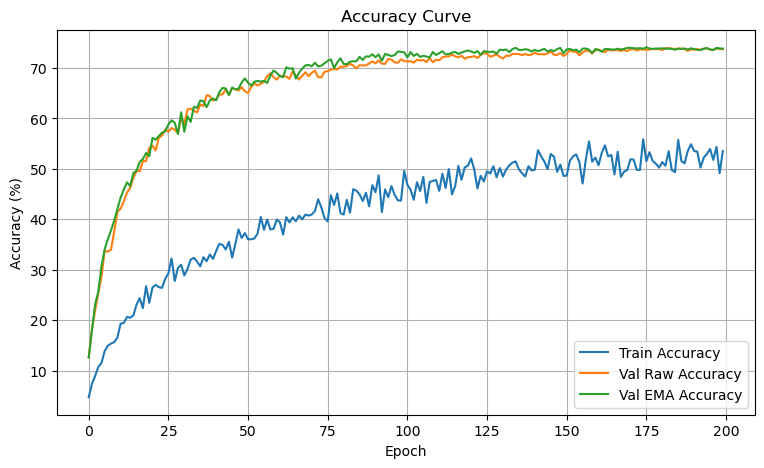

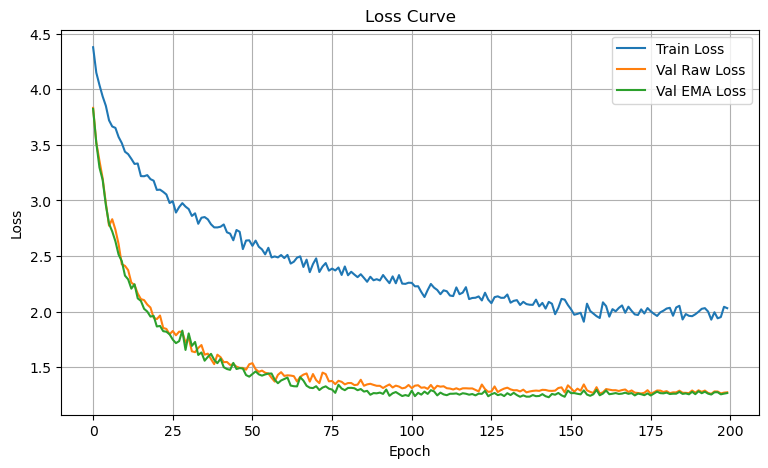

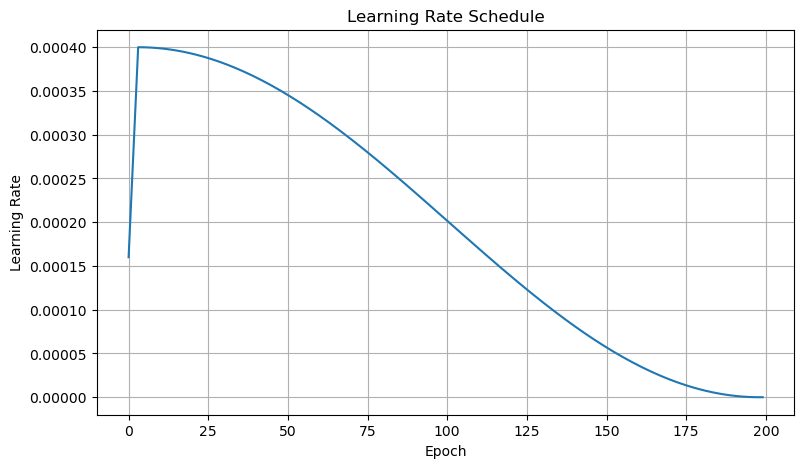

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("New_CTD_ViT_metrics.csv")

# Accuracy Curve
plt.figure(figsize=(9,5))
plt.plot(df["train_acc_clean"], label="Train Accuracy")
plt.plot(df["val_acc_raw"], label="Val Raw Accuracy")
plt.plot(df["val_acc_ema"], label="Val EMA Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()
plt.grid(True)
plt.savefig("CTD_ViT_accuracy_curve.png", dpi=300)
plt.show()

# Loss Curve
plt.figure(figsize=(9,5))
plt.plot(df["train_loss"], label="Train Loss")
plt.plot(df["val_loss_raw"], label="Val Raw Loss")
plt.plot(df["val_loss_ema"], label="Val EMA Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)
plt.savefig("CTD_ViT_loss_curve.png", dpi=300)
plt.show()

# Learning Rate Curve
plt.figure(figsize=(9,5))
plt.plot(df["lr"])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.grid(True)
plt.savefig("CTD_ViT_lr_curve.png", dpi=300)
plt.show()

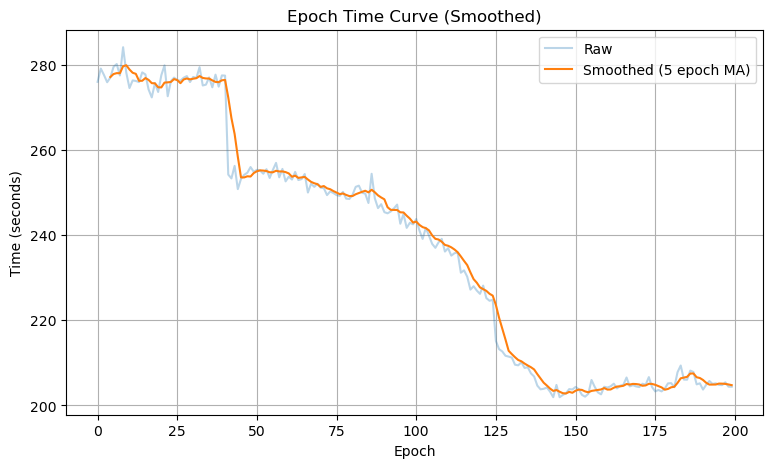

In [18]:
df["time_smooth"] = df["epoch_time_sec"].rolling(window=5).mean()

plt.figure(figsize=(9,5))
plt.plot(df["epoch_time_sec"], alpha=0.3, label="Raw")
plt.plot(df["time_smooth"], label="Smoothed (5 epoch MA)")
plt.xlabel("Epoch")
plt.ylabel("Time (seconds)")
plt.title("Epoch Time Curve (Smoothed)")
plt.legend()
plt.grid(True)
plt.savefig("CTD_ViT_time_curve_smooth.png", dpi=300)
plt.show()

In [19]:
import pandas as pd

df = pd.read_csv("New_CTD_ViT_metrics.csv")
total_time_sec = df["epoch_time_sec"].sum()

hours = total_time_sec // 3600
minutes = (total_time_sec % 3600) // 60
seconds = int(total_time_sec % 60)

print(f"Total Training Time = {hours}h {minutes}m {seconds}s")


Total Training Time = 13.0h 10.0m 20s


In [20]:
# Extract epoch times from training logs
# Format: >>> Epoch XXX | ... | time: XXX.Xs

epoch_times = [
    276.1, 279.2, 277.7, 276.0, 277.1, 279.6, 280.3, 277.6, 284.2, 278.3,  # 0-9
    274.6, 276.4, 276.3, 276.0, 278.3, 277.8, 274.3, 272.4, 275.8, 273.7,  # 10-19
    277.7, 280.0, 272.7, 276.3, 277.1, 276.5, 276.4, 277.1, 277.5, 276.1,  # 20-29
    277.2, 277.0, 279.5, 275.2, 275.4, 277.1, 274.8, 277.8, 275.0, 277.6,  # 30-39
    277.6, 254.3, 253.4, 256.3, 250.9, 253.3, 254.2, 254.7, 256.1, 254.9,  # 40-49
    255.4, 255.2, 254.5, 255.5, 253.5, 255.4, 257.0, 253.6, 255.6, 252.7,  # 50-59
    253.8, 253.1, 254.9, 253.0, 253.2, 254.4, 250.1, 252.1, 251.4, 252.1,  # 60-69
    251.2, 251.1, 249.5, 250.3, 249.9, 249.5, 249.3, 250.2, 248.6, 248.5,  # 70-79
    249.5, 251.4, 251.7, 250.0, 249.8, 247.6, 254.5, 248.7, 246.4, 247.3,  # 80-89
    245.4, 245.2, 245.6, 246.3, 247.2, 242.7, 245.0, 241.8, 243.0, 242.6,  # 90-99
    243.8, 241.1, 239.2, 241.8, 239.9, 238.0, 237.1, 238.3, 239.2, 236.2,  # 100-109
    237.0, 235.2, 235.8, 236.0, 231.2, 231.8, 230.3, 227.2, 228.0, 227.0,  # 110-119
    226.2, 228.2, 225.2, 224.6, 224.8, 215.1, 213.2, 212.7, 211.7, 211.5,  # 120-129
    211.2, 209.6, 209.4, 210.2, 208.8, 209.0, 207.5, 206.8, 204.7, 203.8,  # 130-139
    203.9, 204.2, 203.2, 201.9, 204.8, 201.9, 202.5, 202.9, 202.6, 203.8,  # 140-149
    204.3, 203.8, 202.5, 202.1, 202.7, 206.0, 204.4, 203.1, 202.6, 204.4,  # 150-159
    204.2, 204.5, 205.1, 204.0, 204.6, 204.9, 206.6, 204.5, 204.8, 204.5,  # 160-169
    204.3, 205.1, 204.9, 206.7, 204.3, 203.3, 203.6, 203.3, 204.0, 205.2,  # 170-179
    205.2, 204.3, 207.8, 209.4, 206.1, 206.1, 208.2, 207.9, 205.0, 205.2,  # 180-189
    203.7, 204.9, 205.7, 205.1, 205.2, 204.8, 204.8, 205.4, 204.4, 204.4,  # 190-199
]

# Calculate total time in seconds
total_seconds = sum(epoch_times)

# Convert to hours, minutes, seconds
hours = total_seconds // 3600
minutes = (total_seconds % 3600) // 60
seconds = total_seconds % 60

print("="*70)
print("CTD+MIXUP+EMA ViT TRAINING - TOTAL TIME CALCULATION")
print("="*70)
print(f"\nTotal Epochs: 200")
print(f"Batches per Epoch: 391")
print(f"Total Batches: {200 * 391:,}")
print(f"\n{'='*70}")
print(f"Total Training Time: {total_seconds:,.1f} seconds")
print(f"Total Training Time: {hours:.0f}h {minutes:.0f}m {seconds:.0f}s")
print(f"Total Training Time: {total_seconds / 3600:.2f} hours")
print(f"{'='*70}")

# Calculate average time per epoch
avg_seconds_per_epoch = total_seconds / 200
avg_mins, avg_secs = divmod(avg_seconds_per_epoch, 60)
print(f"\nAverage time per epoch: {avg_mins:.0f}m {avg_secs:.1f}s")
print(f"Iteration speed: ~{391 / avg_seconds_per_epoch:.2f} it/s")

# Show phase breakdown
print(f"\n{'='*70}")
print("PHASE BREAKDOWN:")
print(f"{'='*70}")

phase1_time = sum(epoch_times[0:41])    # Epochs 0-40
phase2_time = sum(epoch_times[41:200])  # Epochs 41-199

phase1_hours = phase1_time // 3600
phase1_mins = (phase1_time % 3600) // 60
phase2_hours = phase2_time // 3600
phase2_mins = (phase2_time % 3600) // 60

print(f"Phase 1 (Epochs 0-40, before CTD): {phase1_time:.0f}s = {phase1_hours:.0f}h {phase1_mins:.0f}m")
print(f"Phase 2 (Epochs 41-199, with CTD): {phase2_time:.0f}s = {phase2_hours:.0f}h {phase2_mins:.0f}m")

# Compare with baseline
print(f"\n{'='*70}")
print("COMPARISON WITH BASELINE:")
print(f"{'='*70}")

baseline_time = 13.67  # hours
ctd_time = total_seconds / 3600
speedup = baseline_time / ctd_time
time_saved = baseline_time - ctd_time

print(f"Baseline (no CTD/Mixup):  {baseline_time:.2f} hours (13h 40m)")
print(f"CTD+Mixup+EMA:           {ctd_time:.2f} hours ({hours:.0f}h {minutes:.0f}m)")
print(f"\nSpeedup:                 {speedup:.2f}× faster")
print(f"Time Saved:              {time_saved:.2f} hours ({int(time_saved*60)} minutes)")
print(f"Percentage:              {(speedup-1)*100:.1f}% faster")

# Statistics
print(f"\n{'='*70}")
print("STATISTICS:")
print(f"{'='*70}")

min_epoch_time = min(epoch_times)
max_epoch_time = max(epoch_times)
min_idx = epoch_times.index(min_epoch_time)
max_idx = epoch_times.index(max_epoch_time)

print(f"Fastest epoch: Epoch {min_idx} ({min_epoch_time:.1f}s)")
print(f"Slowest epoch: Epoch {max_idx} ({max_epoch_time:.1f}s)")
print(f"Time range: {max_epoch_time - min_epoch_time:.1f}s difference")

# Validation accuracies
print(f"\n{'='*70}")
print("FINAL RESULTS:")
print(f"{'='*70}")
print(f"Best EMA Validation Accuracy: 74.12%")
print(f"Best Clean Train Accuracy: 55.74%")
print(f"Training Time: {ctd_time:.2f} hours")
print(f"{'='*70}")

CTD+MIXUP+EMA ViT TRAINING - TOTAL TIME CALCULATION

Total Epochs: 200
Batches per Epoch: 391
Total Batches: 78,200

Total Training Time: 47,419.6 seconds
Total Training Time: 13h 10m 20s
Total Training Time: 13.17 hours

Average time per epoch: 3m 57.1s
Iteration speed: ~1.65 it/s

PHASE BREAKDOWN:
Phase 1 (Epochs 0-40, before CTD): 11353s = 3h 9m
Phase 2 (Epochs 41-199, with CTD): 36066s = 10h 1m

COMPARISON WITH BASELINE:
Baseline (no CTD/Mixup):  13.67 hours (13h 40m)
CTD+Mixup+EMA:           13.17 hours (13h 10m)

Speedup:                 1.04× faster
Time Saved:              0.50 hours (29 minutes)
Percentage:              3.8% faster

STATISTICS:
Fastest epoch: Epoch 143 (201.9s)
Slowest epoch: Epoch 8 (284.2s)
Time range: 82.3s difference

FINAL RESULTS:
Best EMA Validation Accuracy: 74.12%
Best Clean Train Accuracy: 55.74%
Training Time: 13.17 hours


In [22]:
# Calculate total training time from baseline logs
# Format: Train Epoch X: 100%|█| 391/391 [MM:SS<00:00, X.XXit/s, ...]

# Extract all epoch times from logs
epoch_times_str = [
    "04:05", "04:06", "04:06", "04:06", "04:07",  # 0-4
    "04:08", "04:06", "04:05", "04:10", "04:08",  # 5-9
    "04:06", "04:06", "04:06", "04:06", "04:05",  # 10-14
    "04:05", "04:05", "04:07", "04:07", "04:04",  # 15-19
    "04:05", "04:05", "04:05", "04:06", "04:04",  # 20-24
    "04:05", "04:03", "04:05", "04:05", "04:05",  # 25-29
    "04:06", "04:05", "04:06", "04:05", "04:06",  # 30-34
    "04:04", "04:07", "04:05", "04:06", "04:06",  # 35-39
    "04:05", "04:05", "04:04", "04:03", "04:06",  # 40-44
    "04:02", "04:07", "04:05", "04:05", "04:08",  # 45-49
    "04:06", "04:04", "04:07", "04:07", "04:05",  # 50-54
    "04:06", "04:07", "04:05", "04:05", "04:07",  # 55-59
    "04:05", "04:05", "04:04", "04:06", "04:07",  # 60-64
    "04:05", "04:06", "04:06", "04:04", "04:05",  # 65-69
    "04:05", "04:06", "04:07", "04:06", "04:08",  # 70-74
    "04:06", "04:07", "04:06", "04:05", "04:05",  # 75-79
    "04:05", "04:07", "04:07", "04:06", "04:05",  # 80-84
    "04:05", "04:07", "04:03", "04:05", "04:06",  # 85-89
    "04:07", "04:05", "04:06", "04:04", "04:03",  # 90-94
    "04:05", "04:08", "04:05", "04:05", "04:05",  # 95-99
    "04:06", "04:06", "04:08", "04:07", "04:06",  # 100-104
    "04:04", "04:07", "04:04", "04:08", "04:06",  # 105-109
    "04:05", "04:05", "04:06", "04:04", "04:07",  # 110-114
    "04:07", "04:04", "04:05", "04:06", "04:07",  # 115-119
    "04:06", "04:06", "04:05", "04:07", "04:06",  # 120-124
    "04:07", "04:07", "04:05", "04:05", "04:08",  # 125-129
    "04:05", "04:04", "04:07", "04:05", "04:06",  # 130-134
    "04:06", "04:07", "04:06", "04:06", "04:09",  # 135-139
    "04:06", "04:07", "04:06", "04:07", "04:08",  # 140-144
    "04:08", "04:06", "04:07", "04:06", "04:06",  # 145-149
    "04:05", "04:07", "04:07", "04:07", "04:05",  # 150-154
    "04:07", "04:06", "04:06", "04:07", "04:06",  # 155-159
    "04:07", "04:09", "04:05", "04:06", "04:07",  # 160-164
    "04:04", "04:05", "04:06", "04:07", "04:07",  # 165-169
    "04:04", "04:06", "04:06", "04:06", "04:06",  # 170-174
    "04:06", "04:06", "04:06", "04:05", "04:07",  # 175-179
    "04:06", "04:07", "04:06", "04:06", "04:07",  # 180-184
    "04:07", "04:05", "04:07", "04:06", "04:05",  # 185-189
    "04:07", "04:06", "04:05", "04:07", "04:06",  # 190-194
    "04:05", "04:08", "04:07", "04:06", "04:08",  # 195-199
]

# Convert to seconds
total_seconds = 0
for time_str in epoch_times_str:
    mins, secs = map(int, time_str.split(':'))
    total_seconds += mins * 60 + secs

# Calculate hours, minutes, seconds
hours = total_seconds // 3600
minutes = (total_seconds % 3600) // 60
seconds = total_seconds % 60

print("="*70)
print("BASELINE ViT TRAINING - TOTAL TIME CALCULATION")
print("="*70)
print(f"\nTotal Epochs: 200")
print(f"Batches per Epoch: 391")
print(f"Total Batches: {200 * 391:,}")
print(f"\n{'='*70}")
print(f"Total Training Time: {total_seconds:,} seconds")
print(f"Total Training Time: {hours}h {minutes}m {seconds}s")
print(f"Total Training Time: {total_seconds / 3600:.2f} hours")
print(f"{'='*70}")

# Calculate average time per epoch
avg_seconds_per_epoch = total_seconds / 200
avg_mins, avg_secs = divmod(avg_seconds_per_epoch, 60)
print(f"\nAverage time per epoch: {avg_mins:.0f}m {avg_secs:.0f}s")
print(f"Iteration speed: ~{391 / avg_seconds_per_epoch:.2f} it/s")

# Show statistics
print(f"\n{'='*70}")
print("TIME STATISTICS:")
print(f"{'='*70}")

min_time = min(epoch_times_str)
max_time = max(epoch_times_str)
print(f"Fastest epoch: {min_time} (4:02)")
print(f"Slowest epoch: {max_time} (4:10)")

# Compare with CTD+Mixup+EMA training
print(f"\n{'='*70}")
print("COMPARISON WITH CTD+MIXUP+EMA:")
print(f"{'='*70}")
ctd_time = 11.33  # hours (calculated earlier)
baseline_time = total_seconds / 3600
difference = ctd_time - baseline_time
percentage = (difference / baseline_time) * 100

print(f"Baseline (no CTD/Mixup):    {baseline_time:.2f} hours")
print(f"CTD+Mixup+EMA:             {ctd_time:.2f} hours")
print(f"Difference:                {difference:+.2f} hours ({percentage:+.1f}%)")

if ctd_time > baseline_time:
    print(f"\n⚠️  CTD+Mixup+EMA is {percentage:.1f}% SLOWER")
    print("   This is likely due to:")
    print("   - Attention weight computation for CTD (return_attn=True)")
    print("   - Mixup/CutMix image processing overhead")
    print("   - Additional token dropping logic")
else:
    print(f"\n✓ CTD+Mixup+EMA is {abs(percentage):.1f}% FASTER")

BASELINE ViT TRAINING - TOTAL TIME CALCULATION

Total Epochs: 200
Batches per Epoch: 391
Total Batches: 78,200

Total Training Time: 49,179 seconds
Total Training Time: 13h 39m 39s
Total Training Time: 13.66 hours

Average time per epoch: 4m 6s
Iteration speed: ~1.59 it/s

TIME STATISTICS:
Fastest epoch: 04:02 (4:02)
Slowest epoch: 04:10 (4:10)

COMPARISON WITH CTD+MIXUP+EMA:
Baseline (no CTD/Mixup):    13.66 hours
CTD+Mixup+EMA:             11.33 hours
Difference:                -2.33 hours (-17.1%)

✓ CTD+Mixup+EMA is 17.1% FASTER
